In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression
from sklearn import linear_model
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.metrics.pairwise import pairwise_distances
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.cluster.hierarchy import linkage, leaves_list
import time
import itertools
from itertools import combinations, chain


sc.settings.verbosity = 3  

# Load tokens

In [2]:
fpath = "/scratch/indikar_root/indikar1/cstansbu/hematokytos/reference/token_map.csv"

tokens = pd.read_csv(fpath)
print(f"{tokens.shape=}")
tokens.head()

tokens.shape=(25426, 7)


,gene_id,token_id,gene_name,gene_biotype,Chromosome,Start,End
0,<pad>,0,NaN,NaN,NaN,NaN,NaN
1,<mask>,1,NaN,NaN,NaN,NaN,NaN
2,ENSG00000000003,2,TSPAN6,protein_coding,X,100627107.0,100639991.0
3,ENSG00000000005,3,TNMD,protein_coding,X,100584935.0,100599885.0
4,ENSG00000000419,4,DPM1,protein_coding,20,50934866.0,50959140.0


# Load data

In [3]:
# fpath = "/scratch/indikar_root/indikar1/cstansbu/hematokytos/pretrained_embeddings/combat_adata.h5ad"
# fpath = "/scratch/indikar_root/indikar1/cstansbu/hematokytos/pretrained_embeddings/merged_adata.h5ad"
fpath = "/scratch/indikar_root/indikar1/cstansbu/hematokytos/finetuned_embeddings/merged_adata.h5ad"

adata = sc.read_h5ad(fpath)
adata.obs['UMAP 1'] = adata.obsm['X_umap'][:, 0]
adata.obs['UMAP 2'] = adata.obsm['X_umap'][:, 1]
sc.logging.print_memory_usage()
adata

Memory usage: current 0.92 GB, difference +0.92 GB


/home/cstansbu/miniconda3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 171498 × 512
    obs: 'n_genes', 'dataset_x', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'dataset_y', 'standard_cell_type', 'cell_id', 'input_ids', 'length', 'total_length', 'UMAP 1', 'UMAP 2'
    uns: 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

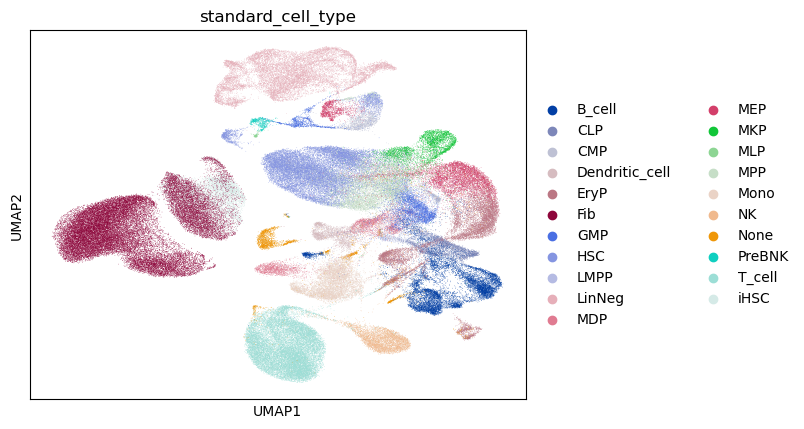

In [4]:
sc.pl.umap(
    adata,
    color=['standard_cell_type'],
)

# Filter types

In [5]:
keep_types = ['HSC', 'iHSC', 'Fib']
adata = adata[adata.obs['standard_cell_type'].isin(keep_types), :].copy()
adata

AnnData object with n_obs × n_vars = 63457 × 512
    obs: 'n_genes', 'dataset_x', 'n_genes_by_counts', 'total_counts', 'obs_index', 'cell_type', 'dataset_y', 'standard_cell_type', 'cell_id', 'input_ids', 'length', 'total_length', 'UMAP 1', 'UMAP 2'
    uns: 'neighbors', 'pca', 'umap', 'standard_cell_type_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [6]:
# add a more nuanced cell type column 

adata.obs['cell_type'] = adata.obs['dataset_x'].astype(str) + "_" + adata.obs['standard_cell_type'].astype(str)
adata.obs['cell_type'].value_counts()

cell_type
tabula_sapiens_Fib         26553
iHSC_iHSC                   8379
sc_fib_Fib                  7736
weng_young2_all_HSC         4996
weng_young1_all_t2_HSC      4845
weng_young1_all_t1_HSC      4509
weng_young2_HSC_HSC         3243
pellin_HSC                  1222
weng_old2_BMMC_HSPC_HSC      934
tabula_sapiens_HSC           760
weng_old1_BMMC_HSPC_HSC      280
Name: count, dtype: int64

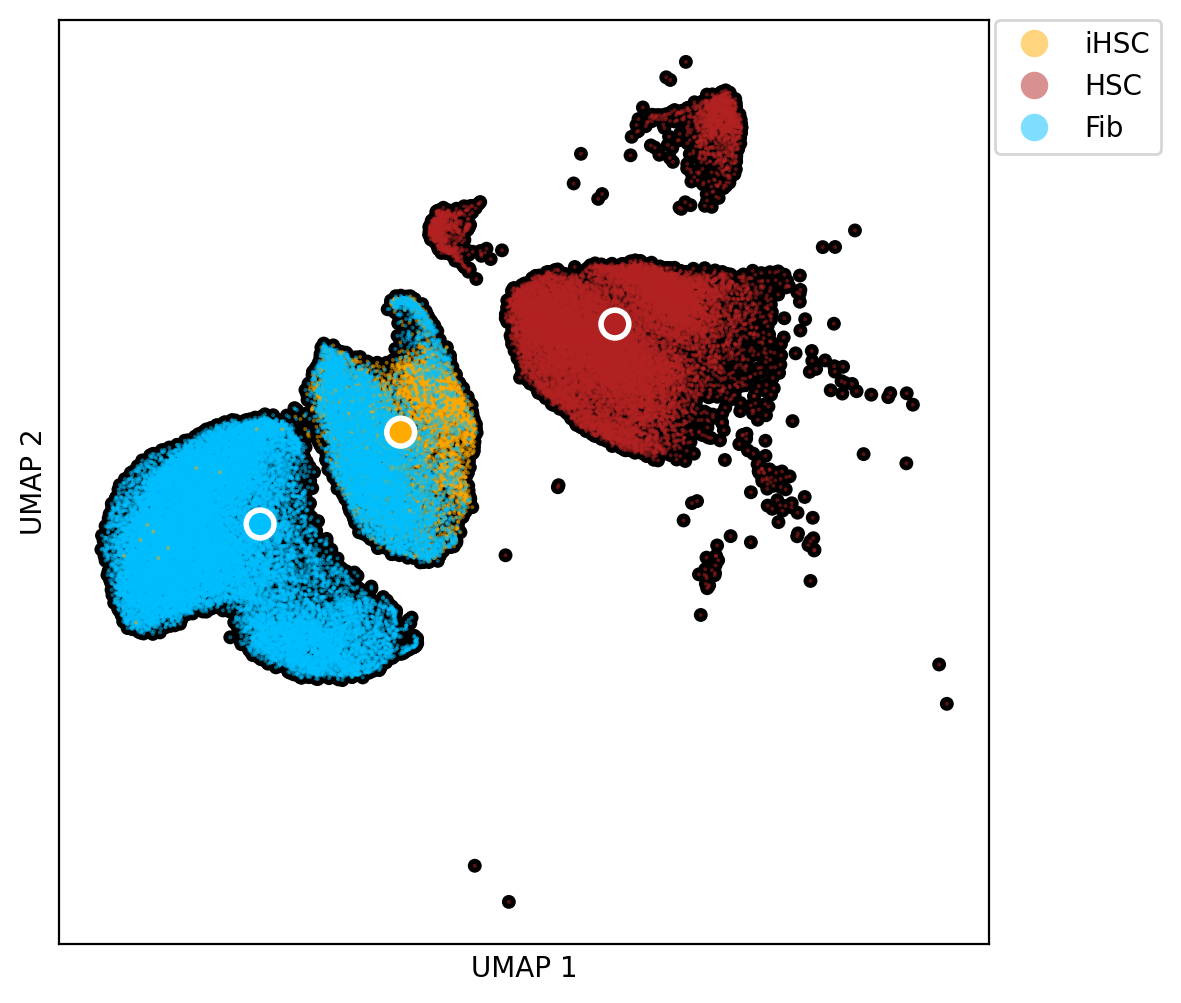

In [7]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

sns.scatterplot(
    data=adata.obs,
    x='UMAP 1',
    y='UMAP 2',
    c='k',
    ec='none',
    s=25,
    zorder=1,
)

sns.scatterplot(
    data=adata.obs,
    x='UMAP 1',
    y='UMAP 2',
    hue='standard_cell_type',
    hue_order=['iHSC', 'HSC', 'Fib'],
    ec='none',
    s=2,
    alpha=0.5,
    palette=['#ffaa00',  'firebrick', 'deepskyblue',],
    zorder=2,
)

# Calculate centroids
centroids = adata.obs.groupby('standard_cell_type', sort=False)[['UMAP 1', 'UMAP 2']].mean()

# Plot centroids
plt.scatter(
    centroids['UMAP 1'],
    centroids['UMAP 2'],
    marker='o',
    s=100,
    c=['firebrick',  'deepskyblue',   '#ffaa00',],
    ec='w',
    linewidths=2,
    zorder=3,
)

plt.xticks([])
plt.yticks([])

plt.gca().set_aspect('auto')

sns.move_legend(
    plt.gca(),
    loc='upper right',
    title="",
    bbox_to_anchor=(1.2, 1.015),
    markerscale=7,
)

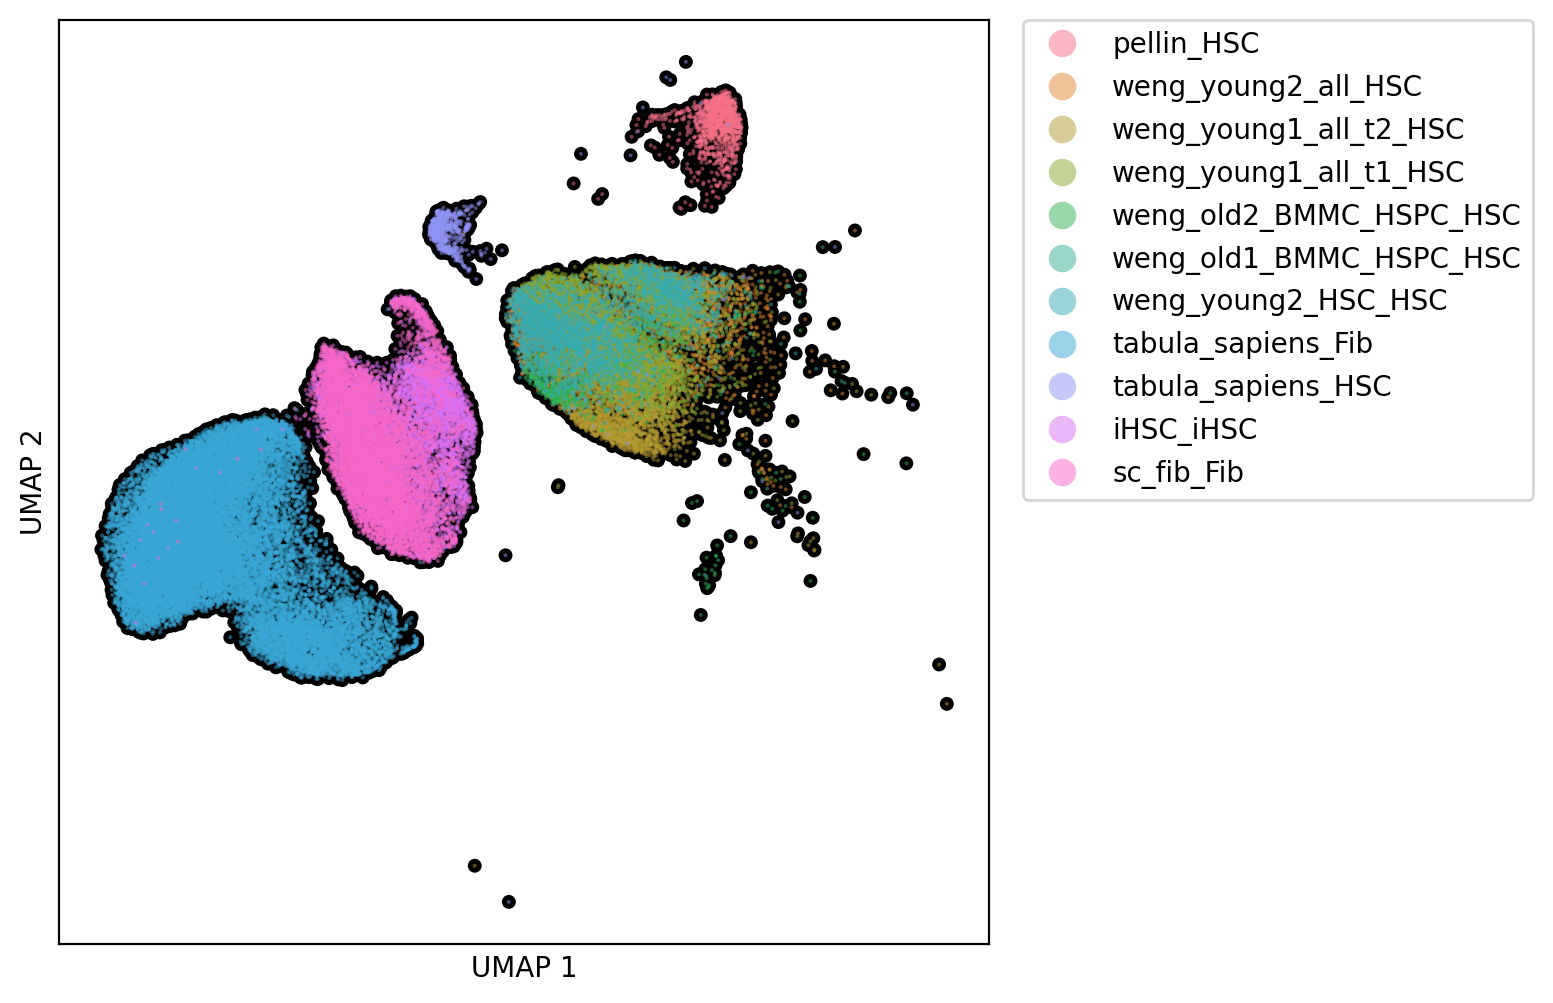

In [8]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 6, 6

sns.scatterplot(
    data=adata.obs,
    x='UMAP 1',
    y='UMAP 2',
    c='k',
    ec='none',
    s=25,
    zorder=1,
)

sns.scatterplot(
    data=adata.obs,
    x='UMAP 1',
    y='UMAP 2',
    hue='cell_type',
    ec='none',
    s=2,
    alpha=0.5,
    zorder=2,
)

plt.xticks([])
plt.yticks([])

plt.gca().set_aspect('auto')

sns.move_legend(
    plt.gca(),
    loc='upper right',
    title="",
    bbox_to_anchor=(1.6, 1.015),
    markerscale=7,
)

# Compute cell type centroids

In [9]:
result = []

for cell_type in adata.obs['cell_type'].unique():    
    X = adata[adata.obs['cell_type'] == cell_type, :].X
    centroid = X.mean(axis=0)
    centroid = pd.DataFrame({ 
        cell_type : centroid
    })
    
    result.append(centroid)
    
result = pd.concat(result, axis=1)
print(f"{result.shape=}")
result = result.T

result.head()    

result.shape=(512, 11)


,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
pellin_HSC,-1.061115,-1.909108,1.616432,-0.055368,0.289369,-1.482985,0.516316,0.382313,0.555941,0.064069,...,0.674301,1.393903,-0.157620,0.214113,0.866256,0.390501,-0.045248,-0.930771,0.059741,-0.264893
weng_young2_all_HSC,-0.377190,-0.375260,1.629507,-0.088811,0.060963,-0.498645,-0.541011,0.548588,0.314699,-0.937918,...,0.555363,1.186918,0.237561,0.767997,-0.033922,0.341751,-0.163563,0.124945,0.692117,-0.527747
weng_young1_all_t2_HSC,-0.418453,-0.460298,1.772965,-0.126672,0.104632,-0.652835,-0.845693,0.410171,0.563481,-0.672585,...,0.229856,1.767843,0.381639,0.825153,0.077430,0.278393,-0.366254,-0.265536,0.327554,-0.386020
weng_young1_all_t1_HSC,-0.382771,-0.236380,1.606238,-0.168856,-0.090776,-0.615283,-0.722842,0.513298,0.239543,-0.999528,...,0.461336,1.519854,0.253567,0.621352,0.000121,0.376476,-0.270234,0.010528,0.903020,-0.459824
weng_old2_BMMC_HSPC_HSC,-0.022875,-1.046183,1.751235,0.176459,0.301805,-0.571334,-0.844644,0.264770,0.397614,-0.825139,...,0.266575,1.361625,0.421784,1.281056,0.008998,0.476952,-0.480408,0.434569,-0.246597,-0.490426


Text(0.5, 310.44444444444434, '')

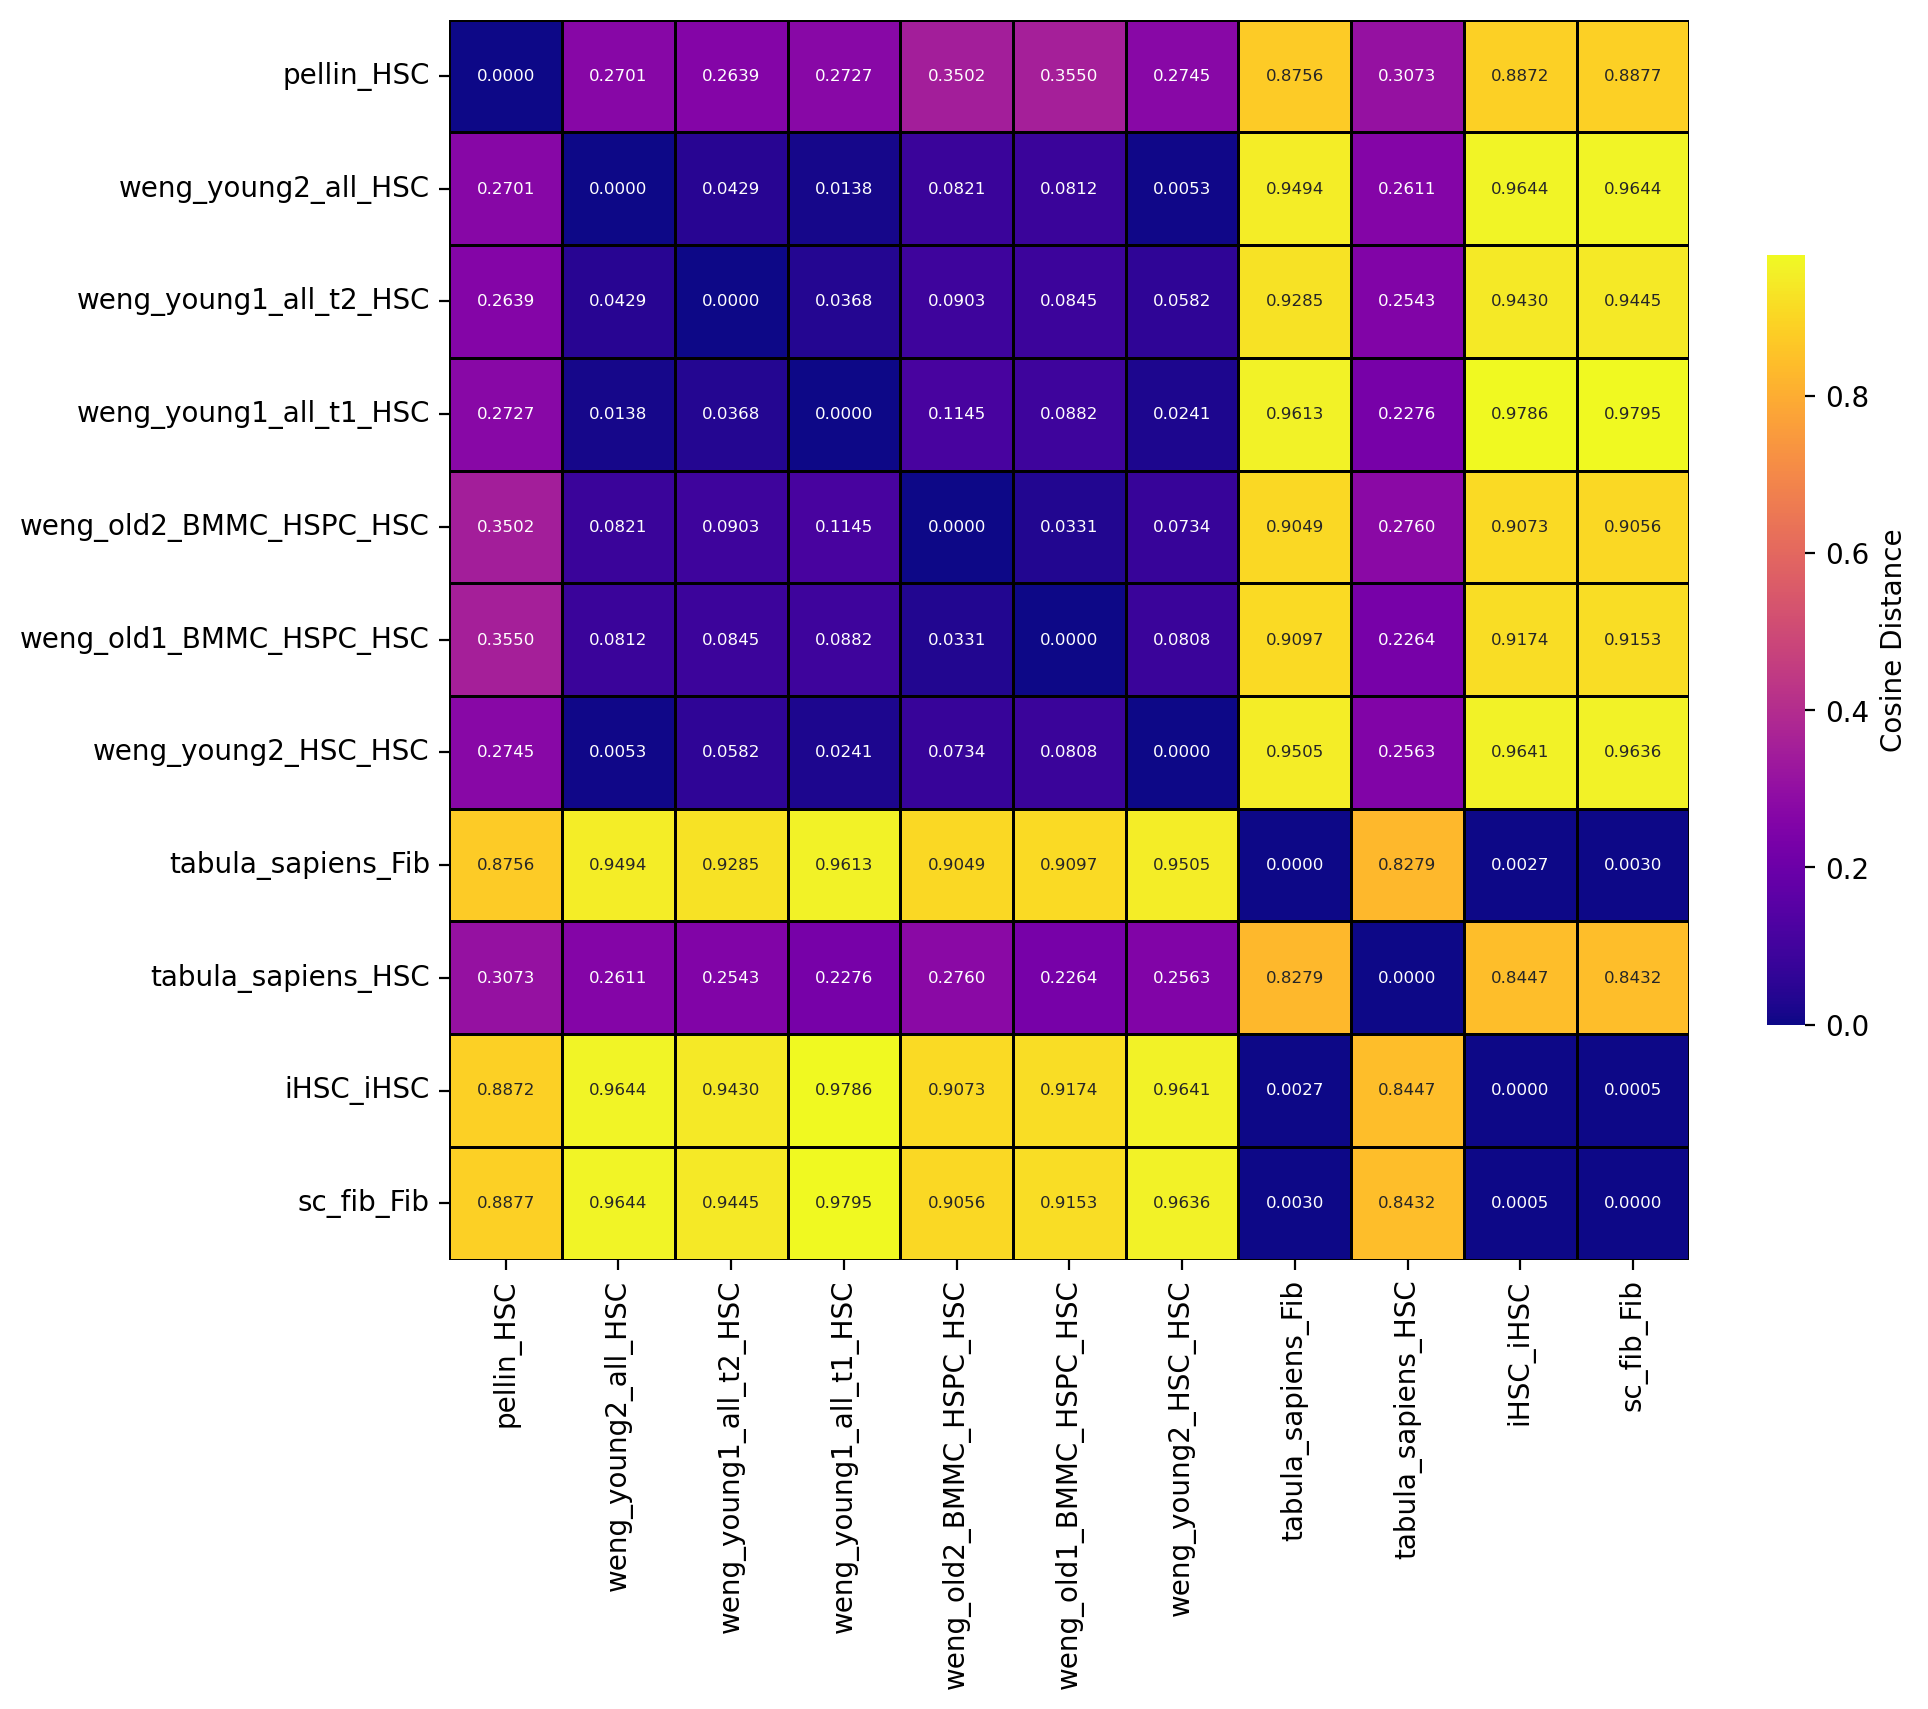

In [10]:
metric = 'cosine'

A = pd.DataFrame(
    squareform(pdist(result, metric=metric)), 
    index=result.index, 
    columns=result.index,
)

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 10

ax = sns.heatmap(
    A,
    square=True,
    linecolor='k',
    lw=1,
    fmt=".4f",
    annot=True,
    annot_kws={'fontsize' : 6},
    cmap='plasma',
    cbar_kws={'shrink': 0.5, 'label' : f'{metric.title()} Distance'}
)

plt.ylabel("")
plt.xlabel("")

# Closest cells

In [11]:
def gather_matrix(adata, use_pca=False):
    # Convert the data to a sparse CSR matrix
    
    if use_pca:
        sparse_matrix = csr_matrix(adata.obsm['X_pca'])
    else:
        sparse_matrix = csr_matrix(adata.X)
    
    columns = [f"comp_{i+1}" for i in range(sparse_matrix.shape[1])]

    # Create a sparse DataFrame from the sparse matrix
    sparse_df = pd.DataFrame.sparse.from_spmatrix(
        sparse_matrix,
        index=adata.obs_names,
        columns=columns
    )
    return sparse_df
    

total_mem = 0
matrix = {} # for the results
indices = {}
for cell_type, group in adata.obs.groupby('cell_type', observed=True):
    
    group_idx = group.index
    indices[cell_type] = group.index
    X = gather_matrix(adata[group_idx, :], use_pca=False)
    
    memory_usage = X.memory_usage(deep=True).sum() / 1024**3
    total_mem += memory_usage
    
    print(f"{cell_type=} {X.shape=} ({memory_usage:.2f} Gb)")
    matrix[cell_type] = X
    
print('done.')
print(f'Total Mem: {total_mem:.2f} Gb')

cell_type='iHSC_iHSC' X.shape=(8379, 512) (0.03 Gb)
cell_type='pellin_HSC' X.shape=(1222, 512) (0.00 Gb)
cell_type='sc_fib_Fib' X.shape=(7736, 512) (0.03 Gb)
cell_type='tabula_sapiens_Fib' X.shape=(26553, 512) (0.10 Gb)
cell_type='tabula_sapiens_HSC' X.shape=(760, 512) (0.00 Gb)
cell_type='weng_old1_BMMC_HSPC_HSC' X.shape=(280, 512) (0.00 Gb)
cell_type='weng_old2_BMMC_HSPC_HSC' X.shape=(934, 512) (0.00 Gb)
cell_type='weng_young1_all_t1_HSC' X.shape=(4509, 512) (0.02 Gb)
cell_type='weng_young1_all_t2_HSC' X.shape=(4845, 512) (0.02 Gb)
cell_type='weng_young2_HSC_HSC' X.shape=(3243, 512) (0.01 Gb)
cell_type='weng_young2_all_HSC' X.shape=(4996, 512) (0.02 Gb)
done.
Total Mem: 0.25 Gb


In [12]:
matrix.keys()

dict_keys(['iHSC_iHSC', 'pellin_HSC', 'sc_fib_Fib', 'tabula_sapiens_Fib', 'tabula_sapiens_HSC', 'weng_old1_BMMC_HSPC_HSC', 'weng_old2_BMMC_HSPC_HSC', 'weng_young1_all_t1_HSC', 'weng_young1_all_t2_HSC', 'weng_young2_HSC_HSC', 'weng_young2_all_HSC'])

In [13]:
mertic = 'euclidean'
root = 'iHSC_iHSC'

comp_list = [
    'sc_fib_Fib',
    'weng_old1_BMMC_HSPC_HSC', 
    'weng_old2_BMMC_HSPC_HSC',
    'weng_young1_all_t1_HSC',
    'weng_young1_all_t2_HSC', 
    'weng_young2_HSC_HSC',
    'weng_young2_all_HSC',
]

result = []

for cell_type in comp_list:
    X = matrix[root]
    Y = matrix[cell_type]    
    D = pairwise_distances(X, Y, metric=metric)
    
    n = D.shape[0]
    
    tmp = pd.DataFrame({
        f'{cell_type}_mean' : D.mean(axis=1),
        f'{cell_type}_std' : D.std(axis=1),
        f'{cell_type}_min' : D.min(axis=1),
        f'{cell_type}_max' : D.min(axis=1),
    }, index=indices[root],)
    result.append(tmp)
    
result = pd.concat(result, ignore_index=False, axis=1)
result = pd.merge(
    result,
    adata.obs,
    how='left',
    left_index=True,
    right_index=True,
)

result.head()

,sc_fib_Fib_mean,sc_fib_Fib_std,sc_fib_Fib_min,sc_fib_Fib_max,weng_old1_BMMC_HSPC_HSC_mean,weng_old1_BMMC_HSPC_HSC_std,weng_old1_BMMC_HSPC_HSC_min,weng_old1_BMMC_HSPC_HSC_max,weng_old2_BMMC_HSPC_HSC_mean,weng_old2_BMMC_HSPC_HSC_std,...,obs_index,cell_type,dataset_y,standard_cell_type,cell_id,input_ids,length,total_length,UMAP 1,UMAP 2
155383,0.007741,0.016407,0.001150,0.001150,0.933761,0.043355,0.820460,0.820460,0.927647,0.035696,...,AAACCCAAGGTTACCT,iHSC_iHSC,iHSC,iHSC,AAACCCAAGGTTACCT_iHSC,[11812 216 15020 ... 11959 18809 11456],2048,2308,1.074859,4.031478
155384,0.008290,0.015690,0.001233,0.001233,0.913394,0.043316,0.801080,0.801080,0.907414,0.035232,...,AAACCCAAGTTGAAGT,iHSC_iHSC,iHSC,iHSC,AAACCCAAGTTGAAGT_iHSC,[11812 16978 16321 ... 14358 13176 19417],2048,2294,-1.256326,4.935823
155385,0.009596,0.014982,0.000807,0.000807,0.929926,0.043600,0.820146,0.820146,0.918226,0.034777,...,AAACCCAAGTTGTCGT,iHSC_iHSC,iHSC,iHSC,AAACCCAAGTTGTCGT_iHSC,[ 4317 436 13345 ... 0 0 0],2048,1649,1.607566,6.289652
155386,0.009891,0.014948,0.001393,0.001393,0.916579,0.044449,0.802790,0.802790,0.907819,0.036362,...,AAACCCACAGAAGCGT,iHSC_iHSC,iHSC,iHSC,AAACCCACAGAAGCGT_iHSC,[11812 4316 10083 ... 0 0 0],2048,1572,1.609719,6.563526
155387,0.006864,0.015995,0.000738,0.000738,0.921141,0.044951,0.805485,0.805485,0.912794,0.036197,...,AAACCCACAGGAGGTT,iHSC_iHSC,iHSC,iHSC,AAACCCACAGGAGGTT_iHSC,[16321 3671 2835 ... 462 12551 14347],2048,3548,0.137653,4.284598


In [14]:
result.columns

Index(['sc_fib_Fib_mean', 'sc_fib_Fib_std', 'sc_fib_Fib_min', 'sc_fib_Fib_max',
       'weng_old1_BMMC_HSPC_HSC_mean', 'weng_old1_BMMC_HSPC_HSC_std',
       'weng_old1_BMMC_HSPC_HSC_min', 'weng_old1_BMMC_HSPC_HSC_max',
       'weng_old2_BMMC_HSPC_HSC_mean', 'weng_old2_BMMC_HSPC_HSC_std',
       'weng_old2_BMMC_HSPC_HSC_min', 'weng_old2_BMMC_HSPC_HSC_max',
       'weng_young1_all_t1_HSC_mean', 'weng_young1_all_t1_HSC_std',
       'weng_young1_all_t1_HSC_min', 'weng_young1_all_t1_HSC_max',
       'weng_young1_all_t2_HSC_mean', 'weng_young1_all_t2_HSC_std',
       'weng_young1_all_t2_HSC_min', 'weng_young1_all_t2_HSC_max',
       'weng_young2_HSC_HSC_mean', 'weng_young2_HSC_HSC_std',
       'weng_young2_HSC_HSC_min', 'weng_young2_HSC_HSC_max',
       'weng_young2_all_HSC_mean', 'weng_young2_all_HSC_std',
       'weng_young2_all_HSC_min', 'weng_young2_all_HSC_max', 'n_genes',
       'dataset_x', 'n_genes_by_counts', 'total_counts', 'obs_index',
       'cell_type', 'dataset_y', 'standard_ce

# compare means

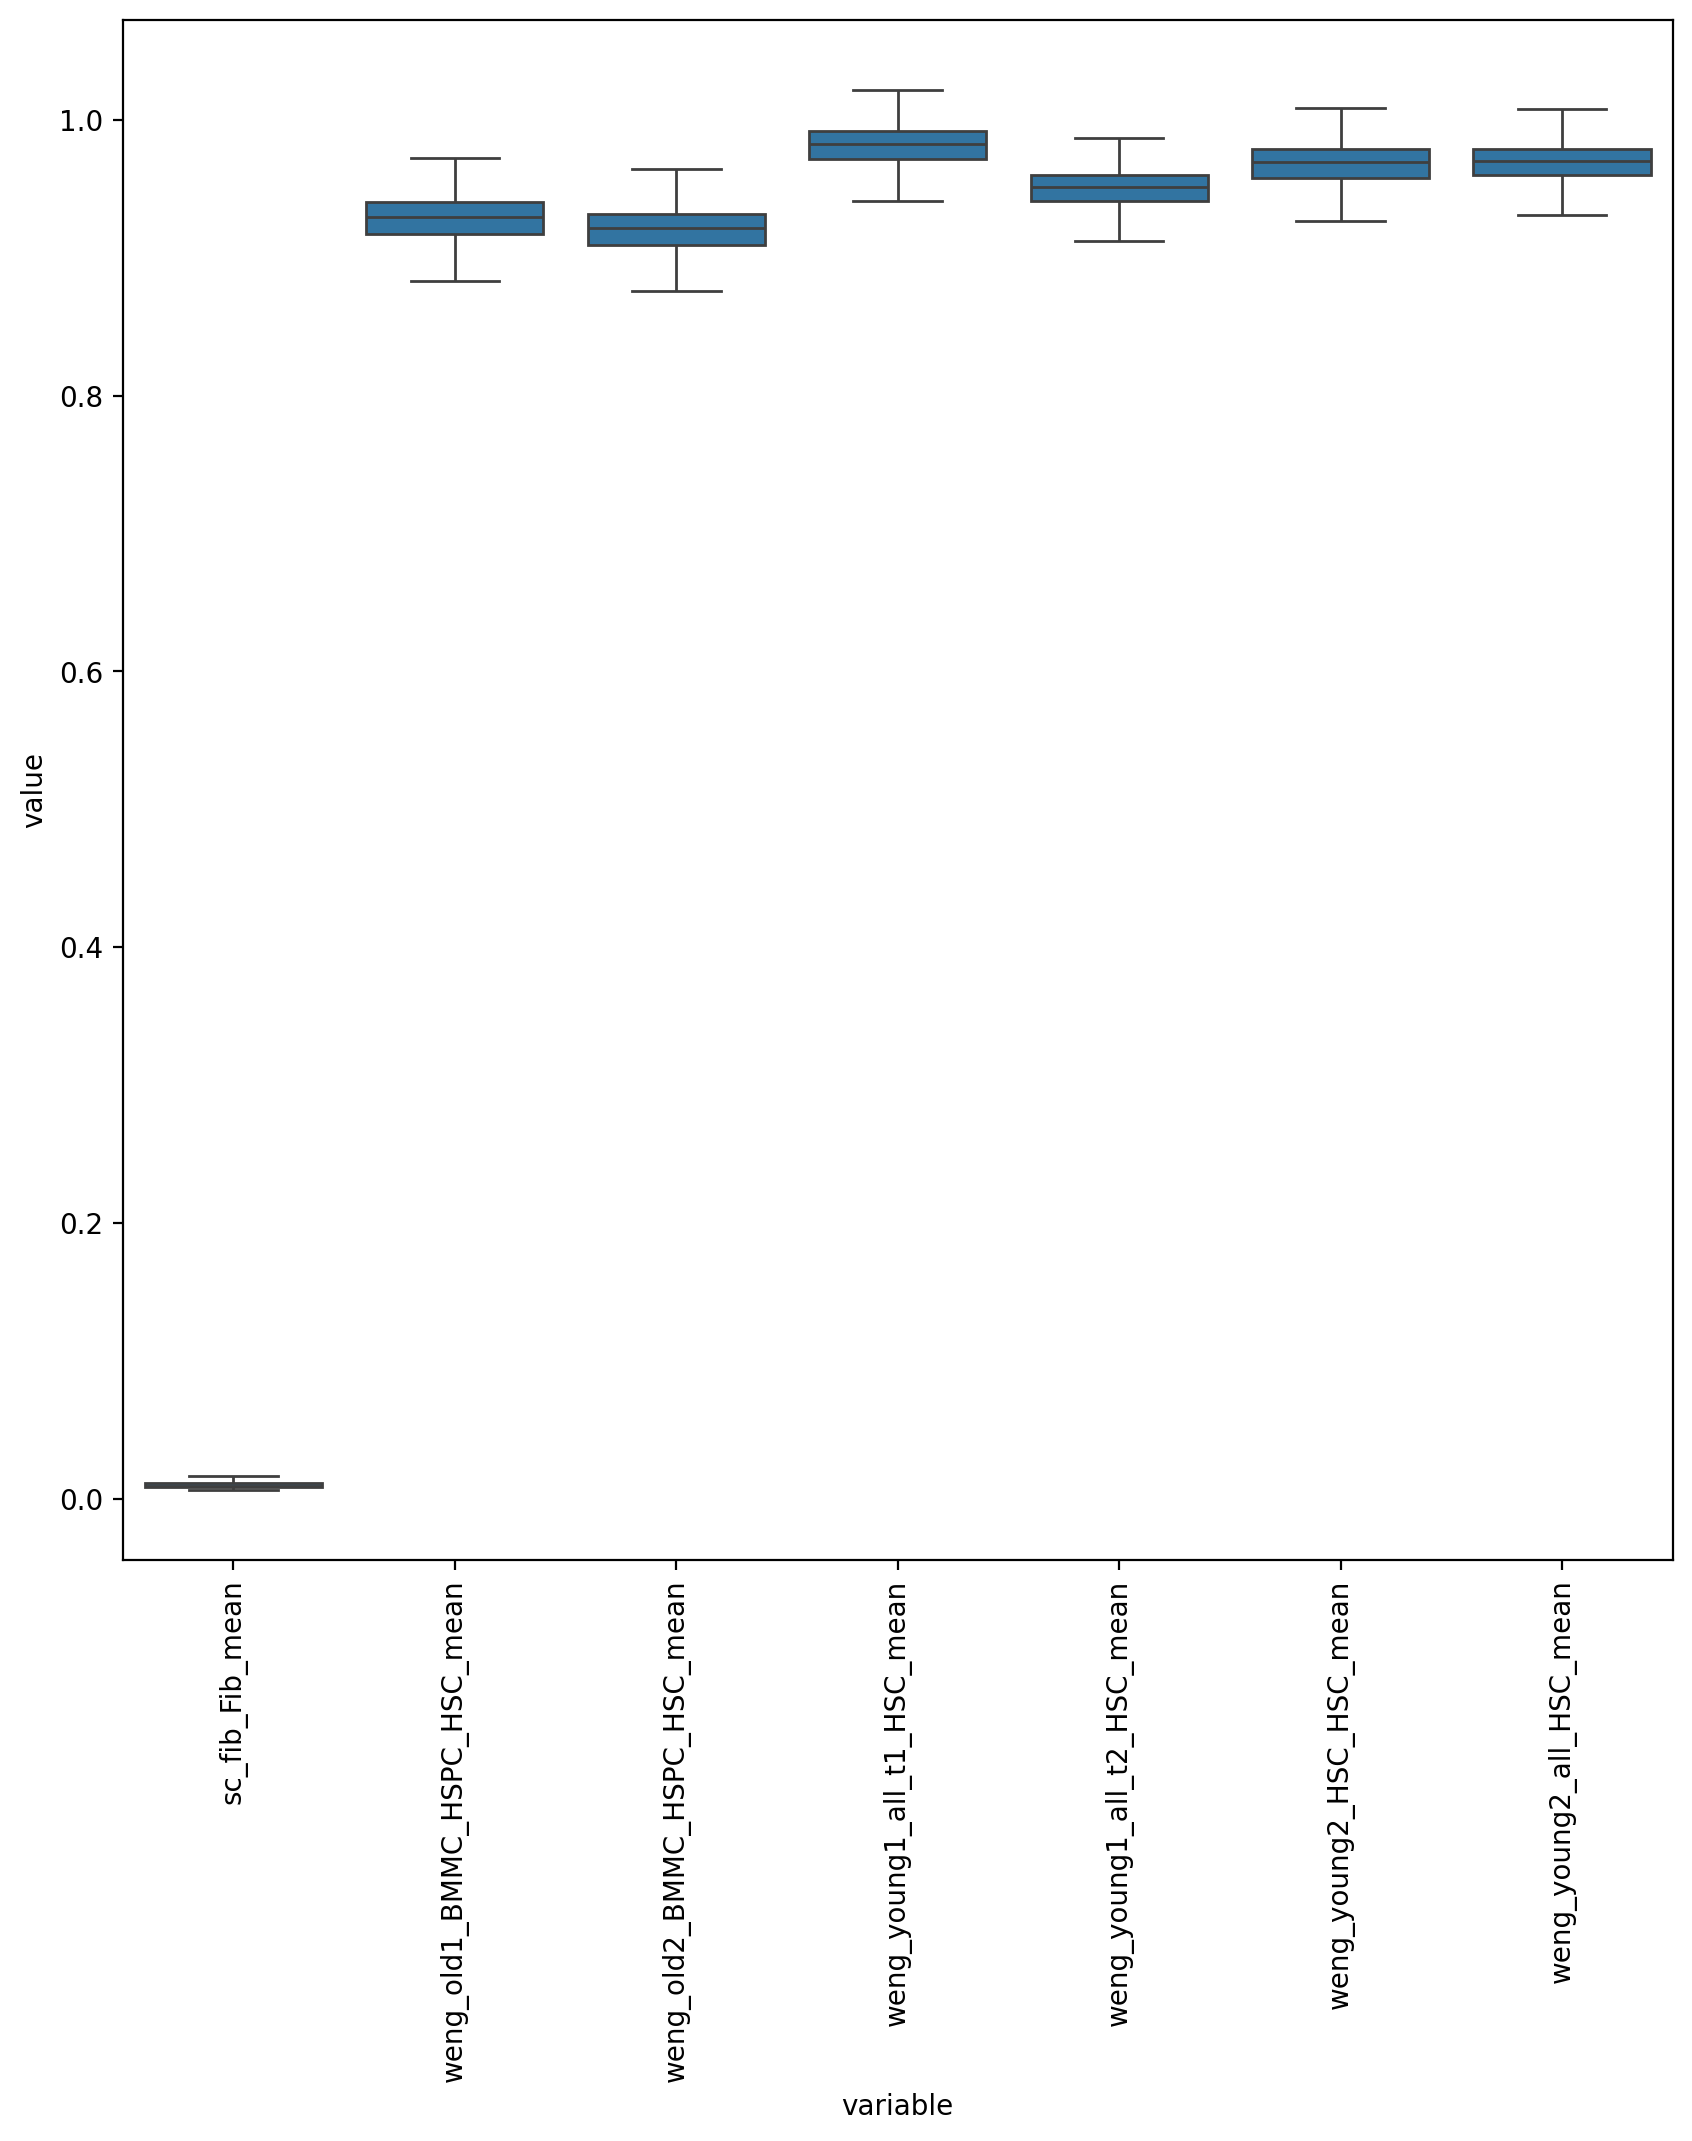

In [15]:
columns = [x for x in result.columns if 'mean' in x]

pdf = result.copy()
pdf = pdf[columns]
pdf = pdf.reset_index(names='cell_id')
pdf = pd.melt(pdf, id_vars='cell_id')

sns.boxplot(
    data=pdf,
    x='variable',
    y='value',
    showfliers=False,
)

plt.gca().tick_params(axis='x', rotation=90)

<Axes: xlabel='UMAP 1', ylabel='UMAP 2'>

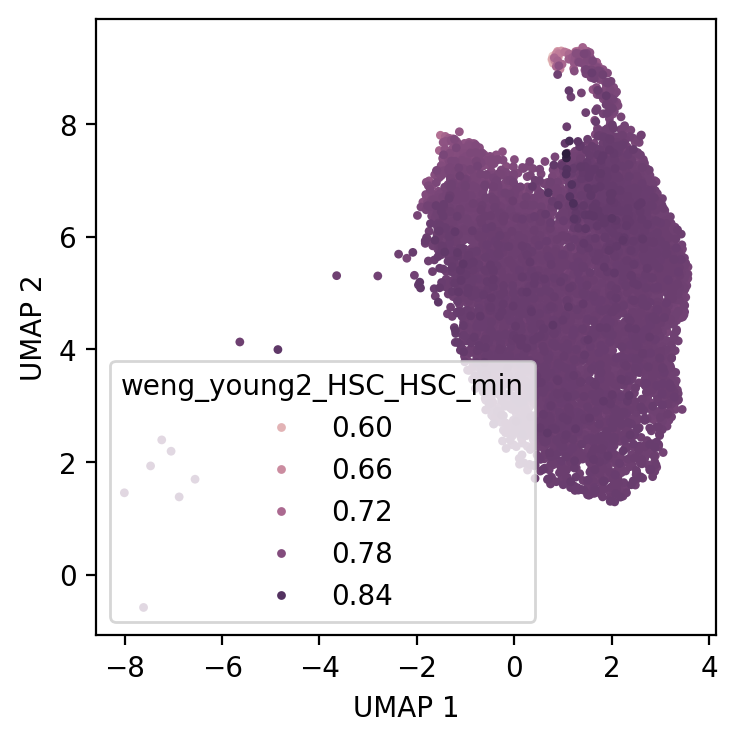

In [16]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 4, 4

column = 'weng_young2_HSC_HSC_min'
sorted_idx = np.argsort(result[column])

sns.scatterplot(
    data=result.iloc[sorted_idx],
    x='UMAP 1',
    y='UMAP 2',
    hue=column,
    ec='none',
    s=10,
)

In [17]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
sns.scatterplot(
    data=result,
    x='sc_fib_Fib_min',
    y='weng_young2_HSC_HSC_min'
)

In [ ]:
break

In [ ]:
indices[root].shape

In [ ]:
break

In [ ]:
adata.obsp['distances'].shape

In [ ]:
break

# Make a more nuanced annotation column

In [ ]:
adata.obs.columns

In [ ]:
adata.obs['cell_type'] = adata.obs['dataset_x'].astype(str) + "_" + adata.obs['standard_cell_type'].astype(str)
adata.obs['cell_type'].value_counts()

# Cell-cell distances

In [ ]:
def gather_matrix(adata, use_pca=False):
    # Convert the data to a sparse CSR matrix
    
    if use_pca:
        sparse_matrix = csr_matrix(adata.obsm['X_pca'])
    else:
        sparse_matrix = csr_matrix(adata.X)
    
    columns = [f"comp_{i+1}" for i in range(sparse_matrix.shape[1])]

    # Create a sparse DataFrame from the sparse matrix
    sparse_df = pd.DataFrame.sparse.from_spmatrix(
        sparse_matrix,
        index=adata.obs_names,
        columns=columns
    )
    return sparse_df
    

total_mem = 0
matrix = {} # for the results
for cell_type, group in adata.obs.groupby('cell_type', observed=True):
    
    group_idx = group.index
    X = gather_matrix(adata[group_idx, :], use_pca=False)
    
    memory_usage = X.memory_usage(deep=True).sum() / 1024**3
    total_mem += memory_usage
    
    print(f"{cell_type=} {X.shape=} ({memory_usage:.2f} Gb)")
    matrix[cell_type] = X
    
print('done.')
print(f'Total Mem: {total_mem:.2f} Gb')
    

In [ ]:
metric = 'cosine'
# metric = 'euclidean'
results = []

start_time = time.time()  # Start timing the entire process

def get_pairs(items):
    pairs = combinations(items, 2)
    self_loops = [(x, x) for x in items]
    return list(chain(pairs, self_loops))

cell_types = list(adata.obs['cell_type'].unique())

# cell_types = list(matrix.keys())
key_pairs = get_pairs(cell_types)
print(f"Considered comparisons: {len(key_pairs)}")


distances = {}

for i, j in key_pairs:
    Xi = matrix[i]
    Xj = matrix[j]
    
    iter_start_time = time.time()  # Start timing this iteration

    D = pairwise_distances(Xi, Xj, metric=metric)
    # D = pd.DataFrame(D, index=Xi.index, columns=Xj.index)

    iter_end_time = time.time()  # End timing this iteration
    print(f"Iteration ({i}, {j}) took {iter_end_time - iter_start_time:.2f} seconds")

    row = {
        'cell_i': i,
        'cell_j': j,
        'N_i': Xi.shape[0],
        'N_j': Xj.shape[0],
        'mean_distance': np.mean(D),
        'std_distance': np.std(D),
        'median_distance': np.median(D),
        'min_distance': np.min(D),
        'max_distance': np.max(D),
        'seconds' : iter_end_time - iter_start_time,
    }
    results.append(row)
    # break  # Remove this break if you want to process all pairs

results = pd.DataFrame(results)

end_time = time.time()  # End timing the entire process
print(f"Total processing time: {end_time - start_time:.2f} seconds")

results.head()

In [ ]:
A = pd.pivot_table(
    results, 
    index='cell_i',
    columns='cell_j',
    values='mean_distance',
    fill_value=0,
)

A = (A.T + A) / 2

print(f"{A.shape=}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 10, 10

ax = sns.heatmap(
    A,
    square=True,
    linecolor='k',
    lw=1,
    fmt=".3f",
    annot=True,
    cmap='plasma',
    cbar_kws={'shrink': 0.5, 'label' : f'{metric.title()} Distance'}
)

plt.ylabel("")
plt.xlabel("")

ax.tick_params(axis='y', rotation=0)
    
plt.show()

In [ ]:
break

In [ ]:
D = adata.obsp['distances']

df = pd.DataFrame.sparse.from_spmatrix(D)
print(f"{df.shape=}")
df.head()


In [ ]:
D = adata.obsp['distances']
print(f"{D.shape=}")


In [ ]:
values = adata.obs['standard_cell_type'].values
cell_types = np.unique(df.columns)
n = len(cell_types)

result = []

for i in range(n):
    for j in range(n):
        ci = cell_types[i]
        cj = cell_types[j]
        
        cidx = values == ci
        cjdx = values == cj
        
        A = df.iloc[cidx, cjdx]
        print(A.shape)
        
        break
    break
        
        
        

In [ ]:
cidx

In [ ]:
break

In [ ]:
X = adata[adata.obs['standard_cell_type'] == 'iHSC', :].X.copy()
Y = adata[adata.obs['standard_cell_type'] == 'HSC', :].X.copy()

print(f"{X.shape=}")
print(f"{Y.shape=}")

D = pairwise_distances(X, Y, metric='euclidean')
D = pd.DataFrame(D)
D.head()

In [ ]:
def sort_like_clustermap(data):
    """Sorts a NumPy array based on hierarchical clustering, 
    similar to seaborn's clustermap.

    Args:
    data: A NumPy array (typically a 2D array for clustermap).

    Returns:
    A tuple containing:
      - sorted_data: The sorted NumPy array.
      - row_indices: The indices used to sort the rows.
      - col_indices: The indices used to sort the columns.
    """
    # Calculate pairwise distances
    row_distances = pdist(data)
    col_distances = pdist(data.T)

    # Perform hierarchical clustering
    row_linkage = linkage(row_distances, method='average')
    col_linkage = linkage(col_distances, method='average')

    # Get the sorted indices
    row_indices = leaves_list(row_linkage)
    col_indices = leaves_list(col_linkage)

    # Sort the data
    sorted_data = data[row_indices, :][:, col_indices]

    return sorted_data, row_indices, col_indices

D_sorted, _, _ = sort_like_clustermap(D)
plt.imshow(D_sorted)

In [ ]:
def fit_line(adata, obs_col, x, y):
    """A function to fit a line to the centroid
    of two groups """
    
    p1 = adata[adata.obs[obs_col] == x, :].X.mean(axis=0)
    p2 = adata[adata.obs[obs_col] == y, :].X.mean(axis=0)

    # Reshape points to be compatible with sklearn
    X = np.vstack((p1, p2))
    y = np.arange(2)  # Assign arbitrary y values (0 and 1)

    model = LinearRegression()
    model.fit(X, y)

    return model
    

reg = fit_line(adata, obs_col='standard_cell_type', x='Fib', y='HSC')
reg

In [ ]:
adata.obs['score'] = reg.predict(adata.X)

mask = (adata.obs['standard_cell_type'] != 'HSC')
sns.scatterplot(
    data=adata.obs[mask],
    x='UMAP 1',
    y='UMAP 2',
    hue='score',
    ec='none',
    s=4,
    alpha=0.5,
    zorder=2,
)


In [ ]:
sns.histplot(
    x=adata.obs['score'],
    bins=31
)

In [ ]:
svd = TruncatedSVD(n_components=2)
eig = svd.fit_transform(adata.X)
adata.obs['eig_1'] = np.ravel(eig[:, 0])
adata.obs['eig_2'] = np.ravel(eig[:, 1])

sns.scatterplot(
    data=adata.obs,
    x='eig_1',
    y='eig_2',
    hue='standard_cell_type',
    ec='none',
    s=2,
    alpha=0.5,
    zorder=2,
)

In [ ]:
def fit_line(adata, obs_col, x, y):
    """A function to fit a line to the centroid
    of two groups """
    
    center_x = adata[adata.obs[obs_col] == x, :].X.mean(axis=0)
    center_y = adata[adata.obs[obs_col] == y, :].X.mean(axis=0)
    
    print(center_x.shape, center_y.shape)
    
    
    # break
    
    
fit_line(adata, obs_col='standard_cell_type', x='Fib', y='HSC')